# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

## Import thư viện cần thiết

In [52]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.svg
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.static_evaluation import evaluate_board


## Config đường dẫn

In [53]:
stockfish_path = ".venv/bin/stockfish"
# stockfish_path = ".venv/Scripts/stockfish.exe"

## Stockfish Engine

In [54]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(20)
stockfish.set_depth(20)

In [55]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"] if score["type"] == "cp" else (1000 if score["value"] > 0 else -1000)

## Lấy tập dữ liệu

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

# Load và filter dữ liệu
df = pd.read_csv('analysis.csv').drop(columns=['position_index', 'error', 'nodes_searched', 'total_search_time', 'eval'])

# Lọc dữ liệu cho depth 1-9 và partial_search = False
filtered_df = df[(df['depth'].isin([1, 2, 3, 4, 5, 6, 7])) & (df['completed'] == True) & (df['execution_time'] < 61)]

# Thống kê mô tả cho từng depth
stats = filtered_df.groupby('depth')['execution_time'].describe()

# Làm tròn và định dạng đẹp hơn
stats_formatted = stats.round(4)

# Chuyển đổi thành DataFrame để hiển thị đẹp hơn
stats_df = stats_formatted.reset_index()
stats_df.columns = ['Depth', 'Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']

# Hiển thị bảng với định dạng đẹp
print("=" * 80)
print("THỐNG KÊ THỜI GIAN THỰC THI THEO DEPTH")
print("=" * 80)
print(stats_df.to_string(index=False, float_format='%.4f'))
print("=" * 80)

# Tạo bảng tóm tắt ngắn gọn hơn
summary_stats = filtered_df.groupby('depth')['execution_time'].agg([
    ('Số lượng', 'count'),
    ('Trung bình', 'mean'),
    ('Độ lệch chuẩn', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(4)

print("\nBẢNG TÓM TẮT:")
print("-" * 60)
print(summary_stats.to_string())


THỐNG KÊ THỜI GIAN THỰC THI THEO DEPTH
 Depth    Count    Mean    Std    Min    25%    50%     75%     Max
     1 350.0000  0.0001 0.0004 0.0000 0.0000 0.0000  0.0001  0.0057
     2 350.0000  0.0831 0.1196 0.0015 0.0247 0.0517  0.1010  1.4232
     3 350.0000  0.1713 0.2999 0.0036 0.0443 0.0956  0.1745  2.8013
     4 350.0000  0.5168 0.6415 0.0046 0.1502 0.3194  0.6063  5.5214
     5 348.0000  1.6423 1.7871 0.0234 0.5402 1.1570  2.0325 16.4760
     6 348.0000  3.8057 3.8221 0.0471 1.3962 2.9219  4.9669 34.7296
     7 340.0000 10.6845 8.9903 0.0900 3.4086 8.6838 14.9923 41.4059

BẢNG TÓM TẮT:
------------------------------------------------------------
       Số lượng  Trung bình  Độ lệch chuẩn     Min      Max
depth                                                      
1           350      0.0001         0.0004  0.0000   0.0057
2           350      0.0831         0.1196  0.0015   1.4232
3           350      0.1713         0.2999  0.0036   2.8013
4           350      0.5168         0.641

In [276]:
# Tạo và lưu bảng thống kê thành ảnh
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

# Tạo bảng từ DataFrame
table = ax.table(cellText=stats_df.values, colLabels=stats_df.columns,
                cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Định dạng header
for i in range(len(stats_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('THỐNG KÊ THỜI GIAN THỰC THI THEO DEPTH', 
          fontsize=14, fontweight='bold')
plt.savefig('statistics_table.png', dpi=300, bbox_inches='tight')
plt.close()


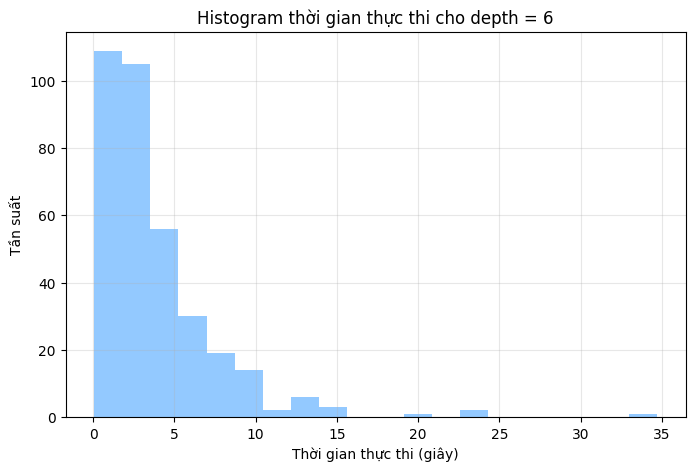

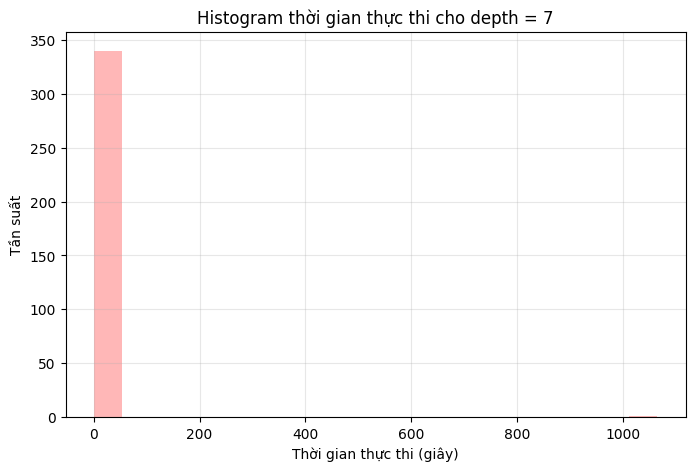

In [ ]:
# Lưu histogram riêng cho depth 6
plt.figure(figsize=(8, 5))
times_6 = filtered_df[filtered_df['depth'] == 6]['execution_time']
plt.hist(times_6, bins=20, alpha=0.7, color='#66b3ff')
plt.xlabel('Thời gian thực thi (giây)')
plt.ylabel('Tần suất')
plt.title('Histogram thời gian thực thi cho depth = 6')
plt.grid(True, alpha=0.3)
plt.savefig('histogram_depth_6_only.png', dpi=300, bbox_inches='tight')
plt.show()

# Lưu histogram riêng cho depth 7
plt.figure(figsize=(8, 5))
times_7 = filtered_df[(filtered_df['completed'] == True) & (filtered_df['depth'] == 7)].dropna()['execution_time']
plt.hist(times_7, bins=20, alpha=0.7, color='#ff9999')
plt.xlabel('Thời gian thực thi (giây)')
plt.ylabel('Tần suất')
plt.title('Histogram thời gian thực thi cho depth = 7')
plt.grid(True, alpha=0.3)
plt.savefig('histogram_depth_7_only.png', dpi=300, bbox_inches='tight')
plt.show()


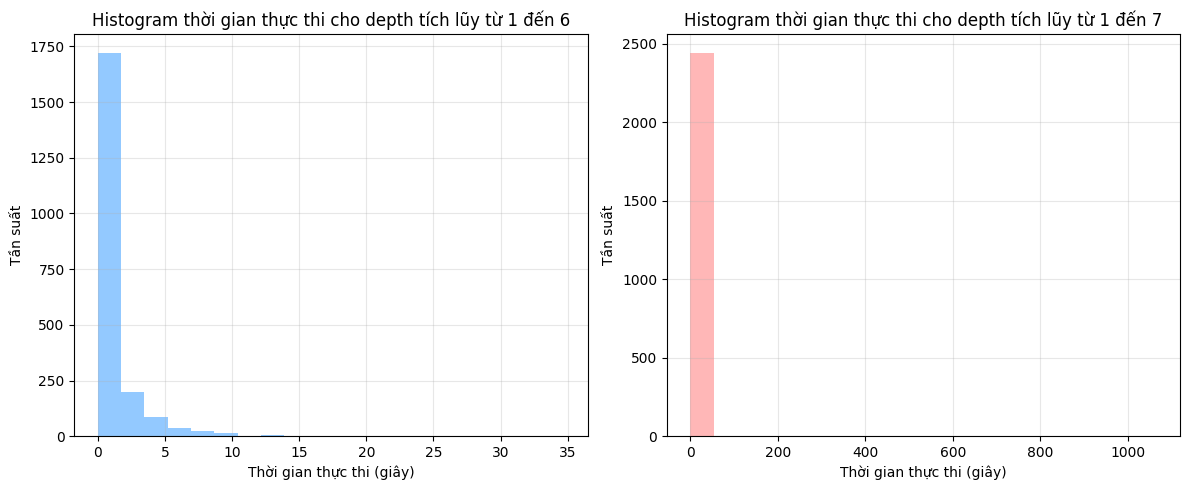

In [237]:
import matplotlib.pyplot as plt

# Vẽ 2 histogram cạnh nhau cho depth tích lũy từ 1->6 và 1->7
plt.figure(figsize=(12, 5))

depths_to_plot = [6, 7]
colors = ['#66b3ff', '#ff9999']

for i, x in enumerate(depths_to_plot):
    plt.subplot(1, 2, i+1)
    # Lọc dữ liệu cho các depth từ 1 đến x (tích lũy)
    times = df[df['depth'].between(1, x)]['execution_time']
    plt.hist(times, bins=20, alpha=0.7, color=colors[i])
    plt.xlabel('Thời gian thực thi (giây)')
    plt.ylabel('Tần suất')
    plt.title(f'Histogram thời gian thực thi cho depth tích lũy từ 1 đến {x}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [70]:
test_fens = df.sample(n=1000, random_state=10)['FEN'].to_list()
stockfish_scores = (
    df.sample(n=1000, random_state=10)['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)  # Remove "+"
    .str.extract(r'([-]?\d+)')[0]       # Extract numbers (returns DataFrame, select column 0)
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()  # Convert to Python list
)

print(stockfish_scores)
print(sum(stockfish_scores))

[-459, 28, -50, 695, 130, 41, 0, -865, -89, -329, -66, -374, 103, 119, 13, 539, 0, 68, 393, -223, 0, 129, 0, 81, -202, 762, 146, -95, 0, 201, -117, -174, 62, 103, -392, 0, 13, -175, 202, -42, -130, 276, 253, -14, -8, 0, 663, 192, 64, -13, 96, 0, -68, 0, 3, -442, 277, -2, -206, 157, -35, -889, -68, -164, 0, -37, 221, -104, -10, -92, 153, -130, 56, 123, 373, 92, -1039, -5997, 175, -389, 80, 119, 414, -235, 38, -343, -22, 210, -24, 109, -939, -13, 13, -16, 114, -112, -56, -49, -82, -116, 31, 68, 636, 34, -312, -1317, 173, -2, -102, 187, 252, 519, -53, -1, 699, 0, 0, 234, 683, 5305, 3, 494, -100, -3, 17, 52, -27, 4, 86, 857, 169, 49, 88, -13, -1246, -49, 84, -138, 101, 86, -185, 97, -106, -40, 0, -5911, -95, 323, -58, -675, 772, 608, 200, 15, 13, 193, -169, 162, 320, -141, -573, 240, -340, 600, 109, 584, 0, 0, 7224, 114, -46, 15, 333, 307, 428, 376, -1, 314, 0, 105, 1557, 53, 81, -80, 681, 204, 841, -79, 162, -1117, 82, 96, -2293, 898, 972, -139, 5364, -779, 285, 56, 804, 221, -20, 211, 45

## Visualization

In [58]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [59]:
showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

# 1. Initialization

In [60]:
def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.
    
    - The first 5 parameters (evaluation weights) are floating-point numbers.
    - The remaining parameters (piece values, penalties, multipliers) are integers.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    # Define bounds for each gene type
    bounds = np.array([
        [-5, 5],   # Evaluation Weight: Material (float)
        [-5, 5],   # Evaluation Weight: King Safety (float)
        [-5, 5],   # Evaluation Weight: Pawn Structure (float)
        [-5, 5],   # Evaluation Weight: Mobility (float)
        [-5, 5],   # Evaluation Weight: Center Control (float)
        [80, 120],   # Pawn Value (int)
        [270, 350],  # Knight Value (int)
        [300, 350],  # Bishop Value (int)
        [450, 550],  # Rook Value (int)
        [850, 1050], # Queen Value (int)
        [9000, 12000], # King Value (int)
        [0, 30],  # Doubled Pawn Penalty (int)
        [0, 30],  # Isolated Pawn Penalty (int)
        [0, 50],   # King Safety Multiplier (int)
        [0, 10],   # Mobility Multiplier (int)
        [0, 20]    # Center Control Multiplier (int)
    ], dtype=float)  # Ensure correct handling of float vs int

    num_params = len(bounds)

    # Generate population matrix
    population = np.zeros((size, num_params))

    for i in range(num_params):
        low, high = bounds[i]
        if i < 5:  # First 5 values are floating-point (evaluation weights)
            population[:, i] = np.random.uniform(low, high, size=size)
        else:  # Remaining values are integers
            population[:, i] = np.random.randint(low, high + 1, size=size)

    return population

# Generate population with 200 individuals
population = initialize_population(200)

# Print first 3 individuals for verification
print(population[:3])


[[ 2.52736650e+00 -2.49313119e+00  2.01472052e+00  4.73118676e+00
   2.50901371e+00  1.03000000e+02  3.09000000e+02  3.43000000e+02
   4.54000000e+02  8.63000000e+02  9.13100000e+03  2.50000000e+01
   2.90000000e+01  2.70000000e+01  1.00000000e+00  8.00000000e+00]
 [ 1.16158555e+00  4.12589023e+00 -4.60958673e+00  6.22087632e-01
  -1.09852822e+00  1.19000000e+02  3.08000000e+02  3.06000000e+02
   5.27000000e+02  8.54000000e+02  9.57600000e+03  1.40000000e+01
   1.30000000e+01  1.00000000e+00  1.00000000e+01  2.00000000e+00]
 [ 4.46153452e+00 -3.06788714e+00  3.27573797e+00  5.59331711e-01
   4.80247171e+00  1.19000000e+02  2.74000000e+02  3.33000000e+02
   5.16000000e+02  9.77000000e+02  1.06310000e+04  1.10000000e+01
   1.70000000e+01  2.00000000e+00  6.00000000e+00  1.30000000e+01]]


# Fitness function

In [ ]:
def fitness_function(weights: List[float]) -> float:
    total_error = 0
    for fen, sf_score in zip(test_fens, stockfish_scores):
        eval_score = evaluate_board(fen, weights)
        total_error += (eval_score - sf_score) ** 2
    return -total_error / len(test_fens) # Càng gần giá trị của Stockfish thì fitness càng cao

# Selection

In [62]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [63]:
def crossover_mixed(parent1, parent2, alpha=0.4, crossover_rate=0.5):
    """
    Perform crossover with an adaptive probability.

    Args:
        parent1 (np.array): First parent.
        parent2 (np.array): Second parent.
        alpha (float): Alpha parameter for BLX-α crossover (for floats).
        crossover_rate (float): Probability of crossover.

    Returns:
        np.array: Child with mixed-type values.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    child = np.zeros_like(p1)

    for i in range(len(p1)):
        if np.random.rand() < crossover_rate:  # Perform crossover with given probability
            if i < 5:  # Floating-point genes (evaluation weights)
                min_val, max_val = min(p1[i], p2[i]), max(p1[i], p2[i])
                range_val = max_val - min_val
                child[i] = min_val - alpha * range_val + np.random.rand() * (1 + 2 * alpha) * range_val
            else:  # Integer genes
                child[i] = np.random.choice([p1[i], p2[i]])
        else:
            child[i] = np.random.choice([p1[i], p2[i]])  # Inherit directly from a parent

    return child


# Mutation

In [64]:
def mutate_mixed(individual, mutation_rate=0.3, mutation_strength=0.1):
    """
    Apply adaptive mutation to floating-point and integer genes.

    Args:
        individual (np.array): Individual's genes.
        mutation_rate (float): Probability of mutation.
        mutation_strength (float): Mutation intensity.

    Returns:
        np.array: Mutated individual.
    """
    mutated = np.copy(individual)

    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Mutation occurs with probability
            if i < 5:  # Floating-point mutation (evaluation weights)
                mutated[i] += np.random.normal(0, mutation_strength)
            else:  # Integer mutation (piece values, penalties, multipliers)
                step = np.random.randint(-1, 2)  # Change by -1, 0, or +1
                mutated[i] += step

    return mutated


In [65]:
def adaptive_mutation_rate(generation, max_generations, min_rate=0.1, max_rate=0.4):
    """
    Adaptive mutation rate: Decreases as generations progress.
    """
    return max_rate - (max_rate - min_rate) * (generation / max_generations)

In [66]:

def adaptive_crossover_rate(generation, max_generations, min_rate=0.2, max_rate=0.7):
    """
    Adaptive crossover rate: Increases as generations progress.
    """
    return min_rate + (max_rate - min_rate) * (generation / max_generations)


# GA

In [67]:
def genetic_algorithm(
    fitness_function,
    population_size=100,
    generations=100,
    elite_size=10,
    tournament_size=5,
    convergence_threshold=20
):
    """
    Runs an optimized Genetic Algorithm with adaptive mutation and crossover rates.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals retained.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if no improvement.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf
    no_improvement_count = 0

    for generation in range(generations):
        # Adaptive rates
        mutation_rate = adaptive_mutation_rate(generation, generations)
        crossover_rate = adaptive_crossover_rate(generation, generations)

        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])

        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Stop early if fitness has not improved
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_mixed(p1, p2, crossover_rate=crossover_rate)
            child = mutate_mixed(child, mutation_rate, mutation_strength=0.1)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}, Mutation Rate = {mutation_rate:.3f}, Crossover Rate = {crossover_rate:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -292788.993, Mutation Rate = 0.400, Crossover Rate = 0.200
Generation 2: Best Fitness = -289485.538, Mutation Rate = 0.399, Crossover Rate = 0.203
Generation 3: Best Fitness = -284491.598, Mutation Rate = 0.397, Crossover Rate = 0.205
Generation 4: Best Fitness = -284491.598, Mutation Rate = 0.396, Crossover Rate = 0.208
Generation 5: Best Fitness = -284344.418, Mutation Rate = 0.394, Crossover Rate = 0.210
Generation 6: Best Fitness = -284148.185, Mutation Rate = 0.393, Crossover Rate = 0.213
Generation 7: Best Fitness = -283855.504, Mutation Rate = 0.391, Crossover Rate = 0.215
Generation 8: Best Fitness = -283855.504, Mutation Rate = 0.390, Crossover Rate = 0.217
Generation 9: Best Fitness = -283855.504, Mutation Rate = 0.388, Crossover Rate = 0.220
Generation 10: Best Fitness = -283819.161, Mutation Rate = 0.387, Crossover Rate = 0.223
Generation 11: Best Fitness = -283776.801, Mutation Rate = 0.385, Crossover Rate = 0.225
Generation 12: Best Fitness = 

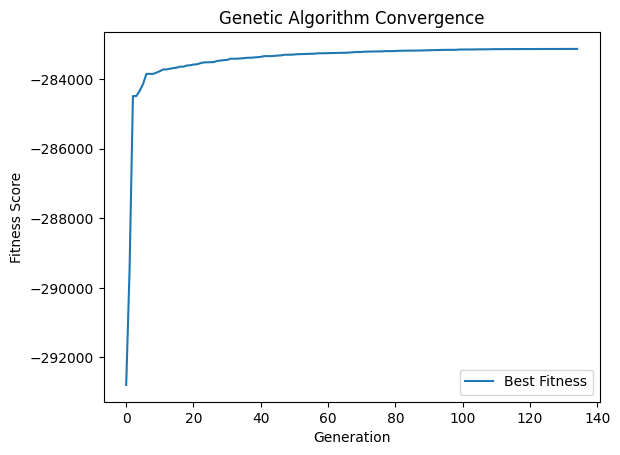

Optimized Weights: [6.16794464e-01 3.49088090e+00 1.07324170e+00 4.02419631e+00
 2.04941519e+00 1.54000000e+02 2.75000000e+02 3.46000000e+02
 4.96000000e+02 8.40000000e+02 9.75400000e+03 3.70000000e+01
 7.00000000e+00 4.00000000e+00 0.00000000e+00 5.00000000e+00]
Suggested weights fitness: -322199.5


In [69]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=200, generations=200, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15,
                100, 300, 320, 500, 900, 10000,
                10, 10,
                20,
                5,
                10
            ]
print("Suggested weights fitness:", fitness_function(chromosomes))